## CNN Model

In [7]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Load dataset
df = pd.read_csv(r"C:\Users\Tian\Desktop\NLP_Task7\Datasets\Corona_NLP_train.csv", encoding='latin1')
df = df[['OriginalTweet', 'Sentiment']].dropna()
df = df[df['Sentiment'].isin(['Positive', 'Negative', 'Neutral'])] 

In [8]:
# Encode labels
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['label'] = df['Sentiment'].map(label_map)

# Preprocess
df['clean_text'] = df['OriginalTweet'].str.lower().str.replace(r"[^\w\s]", "", regex=True)
tokenized_texts = df['clean_text'].str.split()
word_counts = Counter(word for sentence in tokenized_texts for word in sentence)


In [9]:
# Build vocab
vocab = {word: i + 2 for i, word in enumerate(word_counts)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def text_to_seq(text):
    return [vocab.get(word, vocab['<UNK>']) for word in text]

# Convert to tensors
X_seq = [torch.tensor(text_to_seq(sentence)) for sentence in tokenized_texts]
y_seq = torch.tensor(df['label'].values)
X_padded = pad_sequence(X_seq, batch_first=True, padding_value=vocab['<PAD>'])

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_seq, test_size=0.2, random_state=42)

# Dataset wrapper
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=64)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3, 4, 5], num_filters=100):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<PAD>'])
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embed_dim)
        x = x.unsqueeze(1)  # (batch, 1, seq_len, embed_dim)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(batch, num_filters, seq_len - k + 1), ...]
        x = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in x]  # [(batch, num_filters), ...]
        x = torch.cat(x, dim=1)  # (batch, num_filters * len(kernel_sizes))
        x = self.dropout(x)
        return self.fc(x)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5
model.train()

for epoch in range(epochs):
    total_loss, correct, total = 0, 0, 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = outputs.argmax(dim=1)
        correct += (predictions == batch_y).sum().item()
        total += batch_y.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

Epoch 1/5, Loss: 401.5472, Accuracy: 0.4171
Epoch 2/5, Loss: 352.8552, Accuracy: 0.5207
Epoch 3/5, Loss: 324.3989, Accuracy: 0.5800
Epoch 4/5, Loss: 290.1354, Accuracy: 0.6541
Epoch 5/5, Loss: 249.3278, Accuracy: 0.7155



 Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.57      0.60      1943
     Neutral       0.63      0.59      0.61      1512
    Positive       0.63      0.71      0.67      2356

    accuracy                           0.63      5811
   macro avg       0.63      0.62      0.63      5811
weighted avg       0.63      0.63      0.63      5811



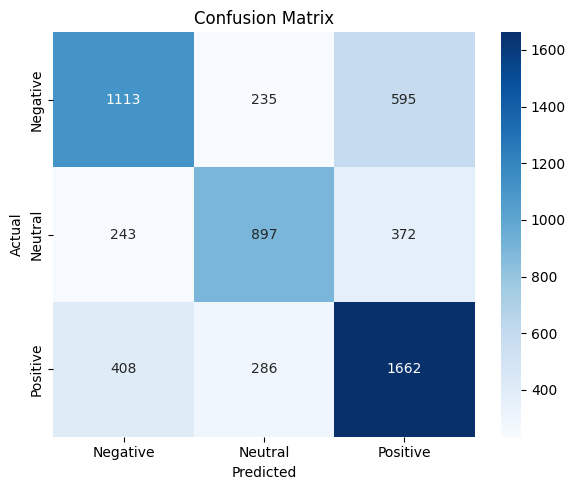

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Classification report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()